# **Campus Scene Detection Project**


## 1. Getting Setup


### MAIN IMPORTS AND VERSIONS CHECK


In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cpu
torchvision version: 0.23.0+cpu


### IMPORTING MANUALLY WRITTEN CODE AS HELPER FUNCTIONS


In [2]:
from Some_Needed_Code import engine_enhanced_new
from Some_Needed_Code.helper_functions import set_seeds

### SETTING THE DEVICE


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. Prepare Dataset


### CHECKING IF DATA IS BALANCED OR NOT


In [ ]:
import os
from collections import Counter

root_dir = "../Dataset"
counts = {
    cls: len(os.listdir(os.path.join(root_dir, cls)))
    for cls in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, cls))
}

for cls, num in sorted(counts.items(), key=lambda x: x[1]):
    print(f"{cls}: {num} images")

total = sum(counts.values())
print("\nTotal images:", total)
print("Average per class:", total / len(counts))

Building: 380 images
Person: 441 images
Lab: 448 images
Car: 556 images
Tree: 580 images

Total images: 2405
Average per class: 481.0


### VISUALIZING CLASS DISTRIBUTION


In [ ]:
import plotly.express as px
import pandas as pd

data = pd.DataFrame(list(counts.items()), columns=["Class", "Number of images"])

fig = px.bar(
    data,
    x="Number of images",
    y="Class",
    orientation="h",  # Ensures it's a horizontal bar chart
    title="Interactive Distribution of Images per Class",
)

fig.show()

### SPLITTING THE DATASET


In [ ]:
from sklearn.model_selection import train_test_split
import os, shutil, glob

source_dir = "../Dataset/Dataset"
dest_dir = "../Dataset_Splitted"

classes = os.listdir(source_dir)
for cls in classes:
    imgs = glob.glob(os.path.join(source_dir, cls, "*.jpg"))
    train, temp = train_test_split(imgs, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for name, split in zip([train, val, test], ["train", "val", "test"]):
        os.makedirs(os.path.join(dest_dir, split, cls), exist_ok=True)
        for img in name:
            shutil.copy(img, os.path.join(dest_dir, split, cls))

### PREPARE THE TRANSOFRMS


In [ ]:
transform = {
    "train": transforms.Compose(
        [
            # 1. Spatial Augmentation: Solves the "squashing" issue and creates "new" images
            # This crops a random part of the image (80%-100%) and resizes it to 224
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            # 2. Orientation: Standard for trees/cars/buildings
            transforms.RandomHorizontalFlip(),
            # 3. Color/Noise Handling: Crucial for your "low res/noisy" images
            # It forces the model to ignore lighting and focus on shapes
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            # 4. Convert to Tensor
            transforms.ToTensor(),
            # 5. Normalization (ImageNet standards)
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            # 6. Regularization (Optional but Pro): Randomly black out small squares
            # Simulates occlusion (e.g., a person walking in front of a car)
            transforms.RandomErasing(p=0.1),
        ]
    ),
    "val": transforms.Compose(
        [
            # Validation Logic: Resize larger, then crop the center.
            # This preserves the aspect ratio so you don't evaluate on "squashed" images.
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

### CREATE "DATASETS" FOR PYTORCH


In [ ]:
data_dir = "../Dataset_Splitted"
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "train"), transform=transform["train"]
)
val_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "val"), transform=transform["val"]
)

### VISUALIZING THE AUGMETATIONS THAT ARE APPLIED TO THE IMAGES


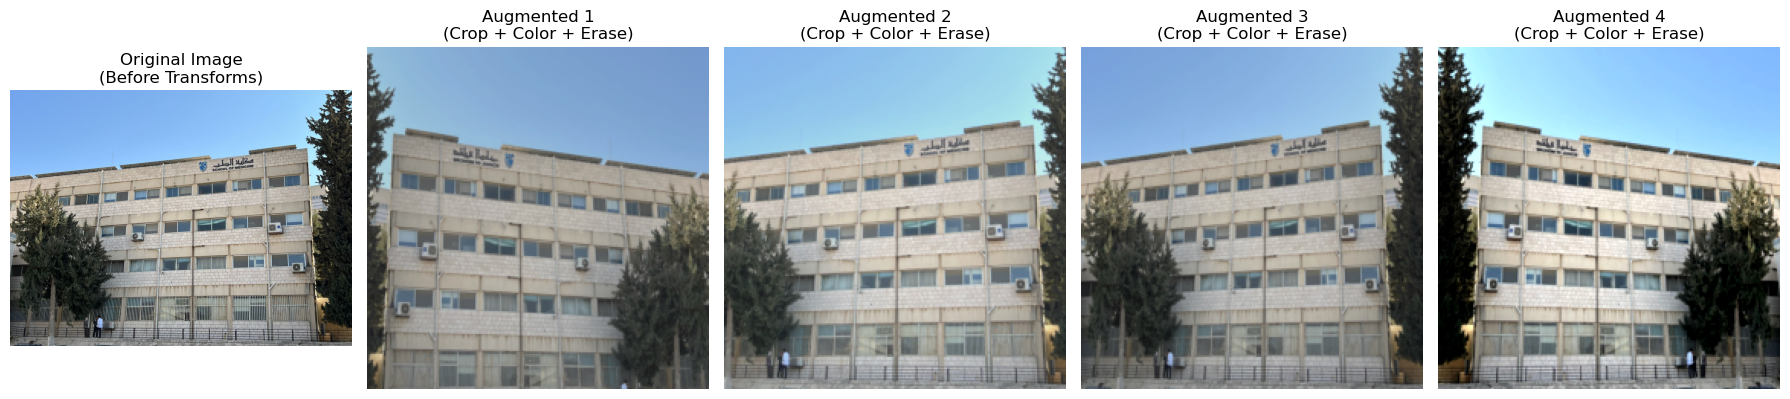

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# 1. Helper to reverse the normalization for visualization
# We need this because matplotlib expects pixel values [0, 1], but your transform
# normalized them to be roughly [-2, 2].
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Convert from Tensor (C, H, W) to numpy (H, W, C)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    # Undo the math: pixel = (pixel * std) + mean
    img = std * img + mean
    return np.clip(img, 0, 1)


# 2. Grab a raw image path from the dataset
# We access .samples[index] to get the file path directly
img_idx = 3
image_path = train_dataset.samples[img_idx][0]
original_img_pil = Image.open(image_path).convert("RGB")

# 3. Plotting
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Plot the Original (Raw)
axes[0].imshow(original_img_pil)
axes[0].set_title("Original Image\n(Before Transforms)")
axes[0].axis("off")

# Plot 4 Randomly Augmented Versions
# We apply transform["train"] 4 times to the SAME image to show variety
for i in range(1, 5):
    # Apply the full pipeline (Crop, Flip, Jitter, Normalize, Erase)
    aug_tensor = transform["train"](original_img_pil)

    # Convert back to viewable image
    viewable_img = denormalize(aug_tensor)

    axes[i].imshow(viewable_img)
    axes[i].set_title(f"Augmented {i}\n(Crop + Color + Erase)")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### APPLYING WieghtedRandomSampler ON THE TRAINING SET


In [ ]:
from torch.utils.data import WeightedRandomSampler

targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

#### MAKING SURE THE SAMPLER WORKED CORRECTLY


In [ ]:
from collections import Counter

sampled_indices = list(sampler)
sampled_classes = [targets[i] for i in sampled_indices]
print(Counter(sampled_classes))

Counter({2: 333, 4: 321, 0: 317, 1: 309, 3: 303})


In [12]:
print(train_dataset.class_to_idx)

{'Building': 0, 'Car': 1, 'Lab': 2, 'Person': 3, 'Tree': 4}


### CREATING THE "DATALOADERS" FOR PYTORCH


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 3. Getting the Pretrained ConvNext-Tiny Model Ready for Training


### IMPORTING THE MODEL FROM TORCHVISION


In [ ]:
from torchvision import models

model_weights = models.ConvNeXt_Tiny_Weights.DEFAULT
model = models.convnext_tiny(weights=model_weights).to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:15<00:00, 7.47MB/s] 


### VISUALIZING THE MODEL'S ARCHITECTURE


In [ ]:
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

### SHOWING MORE INFORMATION ABOUT THE MODEL USING TORCHINFO


In [ ]:
from torchinfo import summary

summary(
    model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     4,704                True
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     192                  True
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   True
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     79,296               True
│  

### FREEZE ALL BASE (FEATURE EXTRACTOR) LAYERS


In [ ]:
for param in model.parameters():
    param.requires_grad = False

# REPLACE THE CLASSIFIER HEAD
num_classes = 5
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

### CHECKING THE MODEL AFTER FREEZING THE PARAMETERS AND ADJUSTING THE HEAD


In [ ]:
from torchinfo import summary

summary(
    model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

## 4. Train the Model and Track the Results


### DEFINE LOSS FUNCTION AND OPTIMIZER


In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

### TRAINING THE MODEL USING MANUALLY WRITTEN SCRIPT FOR THE TRAINING LOOP INSIDE "engine.py"


In [ ]:
set_seeds()
results = engine_enhanced_new.train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device,
    early_stopping_patience=3,
    early_stopping_min_delta=0.001,
)

╭─────────────────────── 🚀 Training Engine ────────────────────────╮
│                                                                   │
│   STARTING TRAINING                                               │
│                                                                   │
│  Start Time: 2025-12-21 17:00:26                                  │
│  Device: cuda                                                     │
│  Epochs: 20                                                       │
│  Early Stopping: Enabled (patience=3, min_delta=0.001, mode=min)  │
│                                                                   │
╰─────────────────────── engine_enhanced.py ────────────────────────╯

Epoch 1/20 — elapsed: 0:00:00

Epoch 1/20 [train]:   2%|    | 1/50 [00:04<03:32,  4.34s/it, Loss=1.6454, BatchLoss=1.6454, Acc=0.1250, Elapsed=0:00:04]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 1/20 [train]:  24%|▋  | 12/50 [01:21<04:36,  7.27s/it, Loss=1.4172, BatchLoss=1.2618, Acc=0.4844, Elapsed=0:01:21]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (91554568 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 1/20 [train]:  38%|█▏ | 19/50 [02:10<03:26,  6.67s/it, Loss=1.2903, BatchLoss=0.9832, Acc=0.6201, Elapsed=0:02:10]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (94024920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 1/20 [train]:  48%

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.9775 │   0.7991 │
│ Val          │ 0.6089 │   0.9528 │
└──────────────┴────────┴──────────┘

Epoch 2/20 — elapsed: 0:07:32

Epoch 2/20 [train]:  10%|▍   | 5/50 [00:36<05:47,  7.71s/it, Loss=0.6091, BatchLoss=0.6257, Acc=0.9375, Elapsed=0:00:36]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (103227860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 2/20 [train]:  14%|▌   | 7/50 [00:52<05:25,  7.57s/it, Loss=0.6157, BatchLoss=0.6376, Acc=0.9420, Elapsed=0:00:52]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90254880 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 2/20 [train]:  60%|█▊ | 30/50 [02:57<01:24,  4.22s/it, Loss=0.5934, BatchLoss=0.5913, Acc=0.9417, Elapsed=0:02:57]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (95892273 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 2/20 [train]:  70%

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.5773 │   0.9476 │
│ Val          │ 0.5239 │   0.9646 │
└──────────────┴────────┴──────────┘

Epoch 3/20 — elapsed: 0:14:00

Epoch 3/20 [train]:   0%|                                                                        | 0/50 [00:00<?, ?it/s]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (95598172 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 3/20 [train]:   2%|    | 1/50 [00:08<06:32,  8.01s/it, Loss=0.5630, BatchLoss=0.5630, Acc=0.9375, Elapsed=0:00:08]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (105008301 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 3/20 [train]:  10%|▍   | 5/50 [00:36<05:16,  7.03s/it, Loss=0.5793, BatchLoss=0.7092, Acc=0.9125, Elapsed=0:00:36]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (95825648 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

c:\Users\Admin\anaconda3

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.5359 │   0.9545 │
│ Val          │ 0.4990 │   0.9705 │
└──────────────┴────────┴──────────┘

Epoch 4/20 — elapsed: 0:21:36

Epoch 4/20 [train]:   2%|    | 1/50 [00:06<05:15,  6.43s/it, Loss=0.5006, BatchLoss=0.5006, Acc=0.9688, Elapsed=0:00:06]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (97505100 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 4/20 [train]:   4%|▏   | 2/50 [00:16<06:55,  8.65s/it, Loss=0.4961, BatchLoss=0.4915, Acc=0.9844, Elapsed=0:00:16]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90753828 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 4/20 [train]:   8%|▎   | 4/50 [00:32<06:03,  7.91s/it, Loss=0.5100, BatchLoss=0.5258, Acc=0.9922, Elapsed=0:00:32]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (92009610 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 4/20 [train]:  18%|

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.5050 │   0.9741 │
│ Val          │ 0.4891 │   0.9764 │
└──────────────┴────────┴──────────┘

Epoch 5/20 — elapsed: 0:28:42

Epoch 5/20 [train]:   0%|                                                                        | 0/50 [00:00<?, ?it/s]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (91869930 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 5/20 [train]:   8%|▎   | 4/50 [00:24<04:27,  5.81s/it, Loss=0.5237, BatchLoss=0.4793, Acc=0.9766, Elapsed=0:00:24]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90732075 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 5/20 [train]:  10%|▍   | 5/50 [00:31<04:46,  6.38s/it, Loss=0.5288, BatchLoss=0.5490, Acc=0.9750, Elapsed=0:00:31]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (98453376 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 5/20 [train]:  18%|

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4983 │   0.9703 │
│ Val          │ 0.4824 │   0.9794 │
└──────────────┴────────┴──────────┘

Epoch 6/20 — elapsed: 0:35:50

Epoch 6/20 [train]:   0%|                                                                        | 0/50 [00:00<?, ?it/s]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (89748990 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 6/20 [train]:   6%|▏   | 3/50 [00:22<05:28,  7.00s/it, Loss=0.4801, BatchLoss=0.4873, Acc=0.9792, Elapsed=0:00:22]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90044310 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 6/20 [train]:   8%|▎   | 4/50 [00:29<05:21,  6.99s/it, Loss=0.4733, BatchLoss=0.4527, Acc=0.9844, Elapsed=0:00:29]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (95808524 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 6/20 [train]:  32%|

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4832 │   0.9792 │
│ Val          │ 0.4769 │   0.9853 │
└──────────────┴────────┴──────────┘

Epoch 7/20 — elapsed: 0:43:10

Epoch 7/20 [train]:   4%|▏   | 2/50 [00:15<06:16,  7.83s/it, Loss=0.4924, BatchLoss=0.5140, Acc=0.9844, Elapsed=0:00:15]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (102356172 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 7/20 [train]:  14%|▌   | 7/50 [00:53<05:09,  7.19s/it, Loss=0.4755, BatchLoss=0.4412, Acc=0.9821, Elapsed=0:00:53]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (91577025 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 7/20 [train]:  22%|▋  | 11/50 [01:22<04:42,  7.23s/it, Loss=0.4765, BatchLoss=0.4513, Acc=0.9801, Elapsed=0:01:22]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (95776494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 7/20 [train]:  24%

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4796 │   0.9785 │
│ Val          │ 0.4720 │   0.9882 │
└──────────────┴────────┴──────────┘

Epoch 8/20 — elapsed: 0:50:42

Epoch 8/20 [train]:  10%|▍   | 5/50 [00:31<04:36,  6.14s/it, Loss=0.5079, BatchLoss=0.5005, Acc=0.9812, Elapsed=0:00:31]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (94906740 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 8/20 [train]:  26%|▊  | 13/50 [01:27<04:08,  6.72s/it, Loss=0.4973, BatchLoss=0.5584, Acc=0.9784, Elapsed=0:01:27]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (105081894 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 8/20 [train]:  42%|█▎ | 21/50 [02:20<02:52,  5.94s/it, Loss=0.4881, BatchLoss=0.4924, Acc=0.9777, Elapsed=0:02:20]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (98199772 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 8/20 [train]:  56%

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4778 │   0.9810 │
│ Val          │ 0.4692 │   0.9882 │
└──────────────┴────────┴──────────┘

Epoch 9/20 — elapsed: 0:57:55

Epoch 9/20 [train]:   4%|▏   | 2/50 [00:15<05:58,  7.46s/it, Loss=0.4720, BatchLoss=0.4836, Acc=0.9688, Elapsed=0:00:15]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (99399006 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (93372216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 9/20 [train]:  14%|▌   | 7/50 [00:52<05:06,  7.13s/it, Loss=0.4727, BatchLoss=0.4767, Acc=0.9777, Elapsed=0:00:52]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (96758056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 9/20 [train]:  26%|▊  | 13/50 [01:39<04:50,  7.84s/it, Loss=0.4730, BatchLoss=0.4480, Acc=0.9784, Elapsed=0:01:39]c:\Users\Admin\anaconda3\

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4745 │   0.9810 │
│ Val          │ 0.4689 │   0.9912 │
└──────────────┴────────┴──────────┘

Epoch 10/20 — elapsed: 5:08:48

Epoch 10/20 [train]:   2%|   | 1/50 [00:04<03:21,  4.11s/it, Loss=0.4300, BatchLoss=0.4300, Acc=1.0000, Elapsed=0:00:04]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (101856098 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (102591489 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 10/20 [train]:   4%|   | 2/50 [00:10<04:17,  5.36s/it, Loss=0.4433, BatchLoss=0.4566, Acc=1.0000, Elapsed=0:00:10]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90902000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 10/20 [train]:   8%|▏  | 4/50 [00:20<03:54,  5.11s/it, Loss=0.4621, BatchLoss=0.4957, Acc=0.9844, Elapsed=0:00:20]c:\Users\Admin\anaconda

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4637 │   0.9855 │
│ Val          │ 0.4661 │   0.9912 │
└──────────────┴────────┴──────────┘

Epoch 11/20 — elapsed: 5:14:02

Epoch 11/20 [train]:  14%|▍  | 7/50 [00:35<03:40,  5.12s/it, Loss=0.4594, BatchLoss=0.4349, Acc=0.9955, Elapsed=0:00:35]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (97431010 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 11/20 [train]:  22%|▍ | 11/50 [00:56<03:17,  5.06s/it, Loss=0.4557, BatchLoss=0.4402, Acc=0.9972, Elapsed=0:00:56]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (92449020 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 11/20 [train]:  24%|▍ | 12/50 [01:01<03:13,  5.09s/it, Loss=0.4622, BatchLoss=0.5336, Acc=0.9948, Elapsed=0:01:01]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (97515814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

c:\Users\Admin\anaconda3\

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4688 │   0.9874 │
│ Val          │ 0.4651 │   0.9882 │
└──────────────┴────────┴──────────┘

Epoch 12/20 — elapsed: 5:19:18

Epoch 12/20 [train]:   6%|▏  | 3/50 [00:14<03:51,  4.92s/it, Loss=0.4496, BatchLoss=0.4437, Acc=1.0000, Elapsed=0:00:14]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (91393372 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 12/20 [train]:  24%|▍ | 12/50 [01:00<03:09,  4.98s/it, Loss=0.4662, BatchLoss=0.4447, Acc=0.9896, Elapsed=0:01:00]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (96089989 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 12/20 [train]:  32%|▋ | 16/50 [01:19<02:46,  4.89s/it, Loss=0.4623, BatchLoss=0.4832, Acc=0.9902, Elapsed=0:01:19]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (103554662 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 12/20 [train]:  36

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4593 │   0.9905 │
│ Val          │ 0.4649 │   0.9882 │
└──────────────┴────────┴──────────┘

Epoch 13/20 — elapsed: 5:24:27

Epoch 13/20 [train]:   8%|▏  | 4/50 [00:18<03:42,  4.83s/it, Loss=0.4566, BatchLoss=0.4794, Acc=0.9766, Elapsed=0:00:18]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (102636898 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 13/20 [train]:  10%|▎  | 5/50 [00:25<04:02,  5.40s/it, Loss=0.4528, BatchLoss=0.4375, Acc=0.9812, Elapsed=0:00:25]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90246093 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 13/20 [train]:  20%|▍ | 10/50 [00:50<03:11,  4.80s/it, Loss=0.4450, BatchLoss=0.4302, Acc=0.9906, Elapsed=0:00:50]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (91756548 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 13/20 [train]:  46

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4562 │   0.9899 │
│ Val          │ 0.4619 │   0.9912 │
└──────────────┴────────┴──────────┘

Epoch 14/20 — elapsed: 5:29:43

Epoch 14/20 [train]:   2%|   | 1/50 [00:04<03:50,  4.70s/it, Loss=0.4328, BatchLoss=0.4328, Acc=1.0000, Elapsed=0:00:04]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (93604296 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 14/20 [train]:  28%|▌ | 14/50 [01:16<03:00,  5.02s/it, Loss=0.4517, BatchLoss=0.4843, Acc=0.9888, Elapsed=0:01:16]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (91471440 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 14/20 [train]:  50%|█ | 25/50 [02:14<02:12,  5.28s/it, Loss=0.4570, BatchLoss=0.4438, Acc=0.9862, Elapsed=0:02:14]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (94614168 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 14/20 [train]:  52%

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4588 │   0.9886 │
│ Val          │ 0.4616 │   0.9882 │
└──────────────┴────────┴──────────┘

Epoch 15/20 — elapsed: 5:35:02

Epoch 15/20 [train]:  18%|▌  | 9/50 [00:48<03:38,  5.34s/it, Loss=0.4647, BatchLoss=0.4471, Acc=0.9896, Elapsed=0:00:48]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90603036 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 15/20 [train]:  32%|▋ | 16/50 [01:25<03:00,  5.30s/it, Loss=0.4625, BatchLoss=0.4793, Acc=0.9902, Elapsed=0:01:25]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (100243390 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 15/20 [train]:  44%|▉ | 22/50 [01:57<02:23,  5.11s/it, Loss=0.4603, BatchLoss=0.4446, Acc=0.9901, Elapsed=0:01:57]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (89935086 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 15/20 [train]:  48

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4565 │   0.9899 │
│ Val          │ 0.4601 │   0.9912 │
└──────────────┴────────┴──────────┘

Epoch 16/20 — elapsed: 5:40:26

Epoch 16/20 [train]:   6%|▏  | 3/50 [00:14<03:46,  4.83s/it, Loss=0.4840, BatchLoss=0.4694, Acc=0.9792, Elapsed=0:00:14]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (106131200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 16/20 [train]:  12%|▎  | 6/50 [00:30<03:48,  5.20s/it, Loss=0.4663, BatchLoss=0.4616, Acc=0.9896, Elapsed=0:00:30]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (96221902 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 16/20 [train]:  14%|▍  | 7/50 [00:35<03:38,  5.07s/it, Loss=0.4648, BatchLoss=0.4559, Acc=0.9866, Elapsed=0:00:35]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (95856736 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 16/20 [train]:  18

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4587 │   0.9867 │
│ Val          │ 0.4602 │   0.9912 │
└──────────────┴────────┴──────────┘

Epoch 17/20 — elapsed: 5:45:26

Epoch 17/20 [train]:   8%|▏  | 4/50 [00:18<03:29,  4.56s/it, Loss=0.4326, BatchLoss=0.4334, Acc=1.0000, Elapsed=0:00:18]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90603450 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 17/20 [train]:  12%|▎  | 6/50 [00:27<03:25,  4.66s/it, Loss=0.4405, BatchLoss=0.4681, Acc=1.0000, Elapsed=0:00:27]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (93369912 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 17/20 [train]:  26%|▌ | 13/50 [00:58<02:38,  4.28s/it, Loss=0.4427, BatchLoss=0.4703, Acc=0.9976, Elapsed=0:00:58]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (92971221 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 17/20 [train]:  32%

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4530 │   0.9918 │
│ Val          │ 0.4591 │   0.9882 │
└──────────────┴────────┴──────────┘

Epoch 18/20 — elapsed: 5:50:10

Epoch 18/20 [train]:   0%|                                                                       | 0/50 [00:00<?, ?it/s]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (102153608 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 18/20 [train]:   4%|   | 2/50 [00:10<04:04,  5.10s/it, Loss=0.4392, BatchLoss=0.4244, Acc=1.0000, Elapsed=0:00:10]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (89857936 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 18/20 [train]:  12%|▎  | 6/50 [00:28<03:17,  4.49s/it, Loss=0.4396, BatchLoss=0.4427, Acc=1.0000, Elapsed=0:00:28]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (101869295 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 18/20 [train]:  1

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4535 │   0.9924 │
│ Val          │ 0.4585 │   0.9912 │
└──────────────┴────────┴──────────┘

Epoch 19/20 — elapsed: 5:55:00

Epoch 19/20 [train]:   6%|▏  | 3/50 [00:13<03:35,  4.58s/it, Loss=0.4818, BatchLoss=0.4470, Acc=0.9792, Elapsed=0:00:13]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (104513352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (90500619 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 19/20 [train]:  22%|▍ | 11/50 [00:51<02:55,  4.49s/it, Loss=0.4640, BatchLoss=0.5051, Acc=0.9858, Elapsed=0:00:51]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (99705300 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 19/20 [train]:  26%|▌ | 13/50 [01:01<02:51,  4.63s/it, Loss=0.4632, BatchLoss=0.4686, Acc=0.9880, Elapsed=0:01:01]c:\Users\Admin\anaconda3

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4502 │   0.9918 │
│ Val          │ 0.4595 │   0.9912 │
└──────────────┴────────┴──────────┘

Epoch 20/20 — elapsed: 6:00:00

Epoch 20/20 [train]:  10%|▎  | 5/50 [00:23<03:30,  4.67s/it, Loss=0.4512, BatchLoss=0.4784, Acc=0.9812, Elapsed=0:00:23]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (93852800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 20/20 [train]:  12%|▎  | 6/50 [00:29<03:45,  5.12s/it, Loss=0.4486, BatchLoss=0.4355, Acc=0.9844, Elapsed=0:00:29]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (95761356 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 20/20 [train]:  16%|▍  | 8/50 [00:40<03:43,  5.32s/it, Loss=0.4475, BatchLoss=0.4496, Acc=0.9883, Elapsed=0:00:40]c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning:

Image size (93956127 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.

Epoch 20/20 [train]:  18%

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.4439 │   0.9943 │
│ Val          │ 0.4583 │   0.9912 │
└──────────────┴────────┴──────────┘

⚠ Early stopping triggered at epoch 20

No improvement for 3 epochs. Best value: 0.4591

╭───────────── ✅ Done ──────────────╮
│                                    │
│   TRAINING COMPLETE 🎉             │
│                                    │
│  Finish Time: 2025-12-21 23:05:22  │
│  Total Duration: 6:04:55           │
│                                    │
╰────────────────────────────────────╯

### SAVING THE MODEL


In [ ]:
from Some_Needed_Code.utils import save_model

save_model(model=model, target_dir="./models", model_name="First_Baseline.pth")

[INFO] Saving model to: models\First_Baseline.pth


## 5. Evaluate the Model


### VISUALIZING LEARNING CURVES


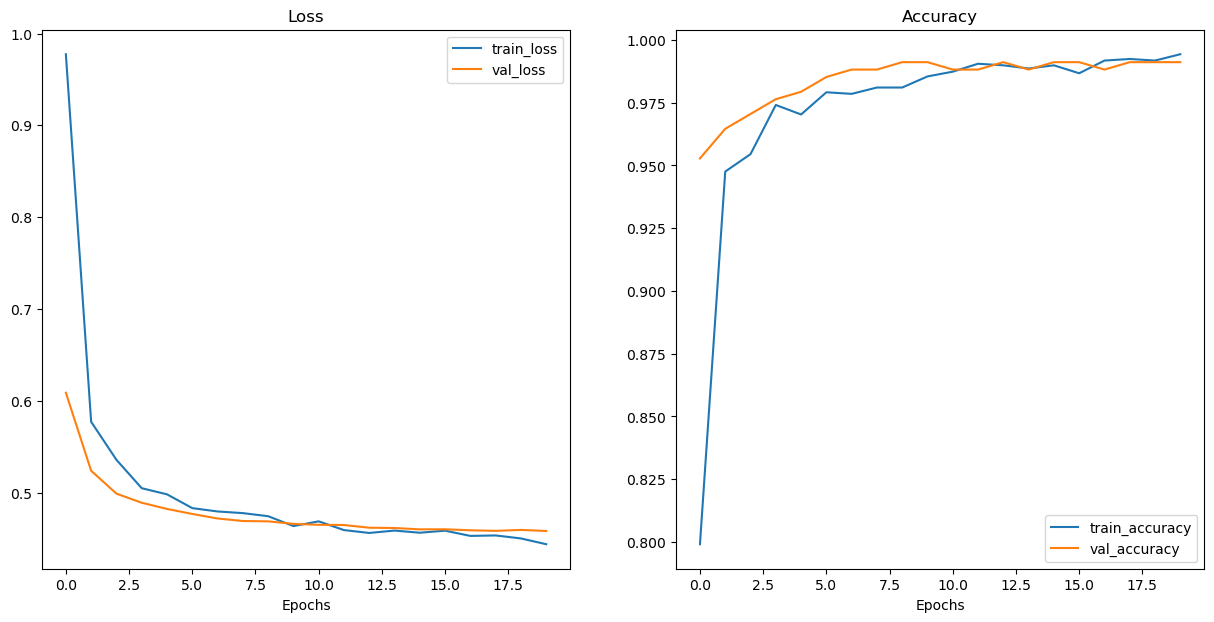

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    # Check the Loss Curves


plot_loss_curves(results)

### LOADING THE "STATE DICT" OF THE MODEL TO EVALUATE IT


In [ ]:
from torchvision import models

model = models.convnext_tiny(weights=None, num_classes=5)

checkpoint_path = "./models/First_Baseline.pth"

state_dict = torch.load(checkpoint_path, map_location=device)

try:
    model.load_state_dict(state_dict)
    print("Weights loaded successfully.")
except RuntimeError as e:
    print(f"Error loading weights: {e}")
    print("Tip: Check if your 'num_classes' matches the training configuration.")

model = model.to(device)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2928\2621999164.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)

Weights loaded successfully.


### MAKING SOME PREDICTIONS ON RANDOM IMAGES FROM THE TEST SET


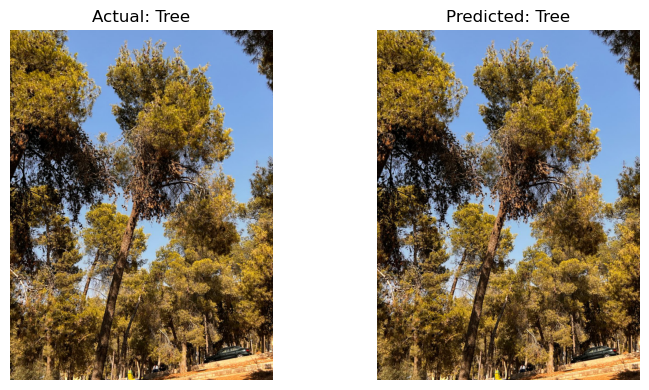

In [ ]:
import os
import random
from torchvision import transforms
from PIL import Image

# --- CONFIG ---
test_dir = "../Dataset_Splitted/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- TRANSFORMS ---
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# --- PICK RANDOM IMAGE ---
classes = sorted(os.listdir(test_dir))
random_class = random.choice(classes)
class_dir = os.path.join(test_dir, random_class)
random_image = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, random_image)

# --- LOAD IMAGE ---
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# --- PREDICT ---
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)
pred_class = classes[predicted.item()]

# --- PLOT ORIGINAL & PREDICTED ---
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(Image.open(img_path))
plt.title(f"Actual: {random_class}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(Image.open(img_path))
plt.title(f"Predicted: {pred_class}")
plt.axis("off")

plt.tight_layout()
plt.show()

### VISUALIZING THE CONFUSION MATRIX


Evaluating model on validation set...


c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



--- Detailed Classification Report ---
              precision    recall  f1-score   support

    Building     1.0000    0.9649    0.9821        57
         Car     1.0000    0.9839    0.9919        62
         Lab     1.0000    1.0000    1.0000        67
      Person     1.0000    1.0000    1.0000        66
        Tree     0.9667    1.0000    0.9831        87

    accuracy                         0.9912       339
   macro avg     0.9933    0.9898    0.9914       339
weighted avg     0.9914    0.9912    0.9912       339



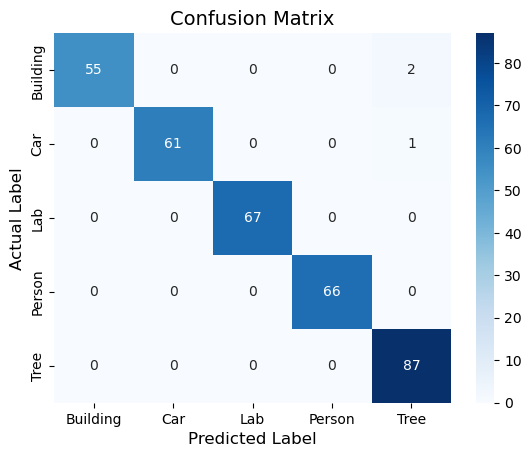

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()  # Set model to evaluation mode

y_true = []
y_pred = []

# 2. Iterate through the validation loader (No Gradient needed)
print("Evaluating model on validation set...")
with torch.inference_mode():  # Faster than torch.no_grad()
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.cpu().numpy()  # Move to CPU for metrics

        # Forward pass
        outputs = model(inputs)

        # Get predictions (class with highest probability)
        _, predictions = torch.max(outputs, 1)
        predictions = predictions.cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(predictions)

# 3. Get Class Names
class_names = train_dataset.classes  # ['Building', 'Car', 'Lab', 'Person', 'Tree']

# 4. Generate Classification Report (Precision, Recall, F1)
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# 5. Generate Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# 6. Plot the Confusion Matrix plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.ylabel("Actual Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

### VISUALIZING GRAD-CAM ON RANDOM IMAGES FROM THE VALIDATION SET


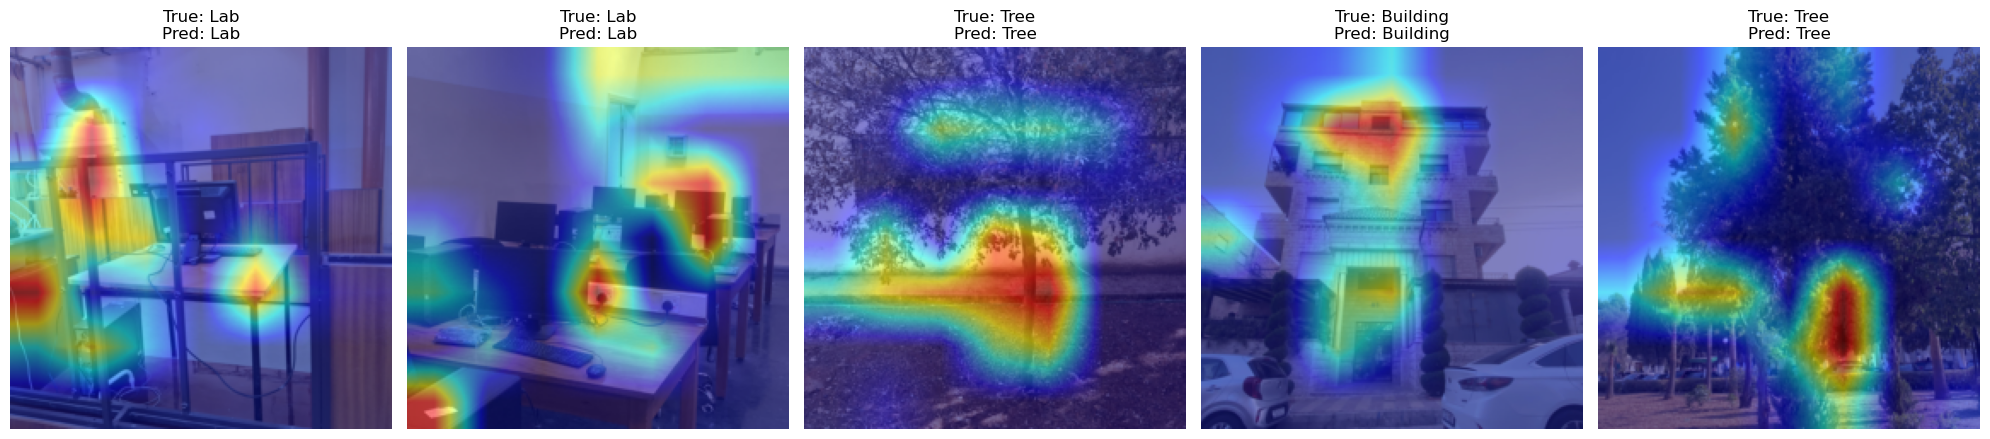

In [ ]:
import random
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import matplotlib.pyplot as plt


target_layers = [model.features[-1][-1]]

cam = GradCAM(model=model, target_layers=target_layers)


viz_loader = torch.utils.data.DataLoader(
    val_loader.dataset,
    batch_size=val_loader.batch_size,
    shuffle=True,  # <--- This ensures you get a random batch each time
)

images, labels = next(iter(viz_loader))
images = images.to(device)

grayscale_cam = cam(input_tensor=images, targets=None)

class_names = train_dataset.classes
plt.figure(figsize=(20, 8))

for i in range(5):  # Show first 5 images in the batch
    img = images[i].cpu().permute(1, 2, 0).numpy()

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    visualization = show_cam_on_image(img, grayscale_cam[i, :], use_rgb=True)

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(visualization)
    true_label = class_names[labels[i].item()]

    output = model(images[i].unsqueeze(0))
    pred_label = class_names[output.argmax().item()]

    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
    plt.axis("off")


plt.tight_layout()
plt.show()

### VISUALIZING T-SNE


Extracting features for t-SNE...


c:\Users\Admin\anaconda3\envs\dl_env\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


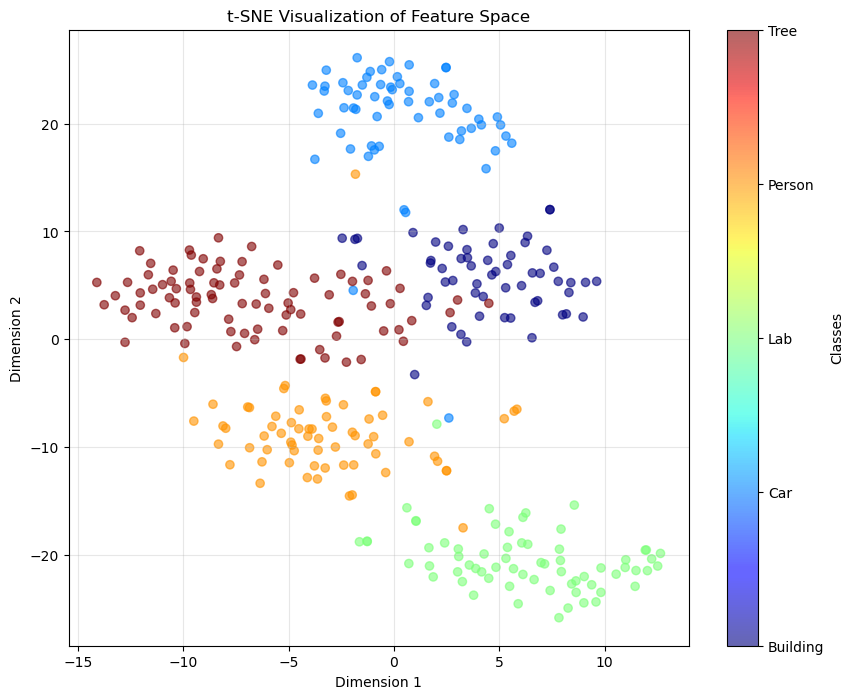

In [ ]:
from sklearn.manifold import TSNE

features_list = []
labels_list = []

print("Extracting features for t-SNE...")
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)

        features = model.features(inputs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)

        features_list.append(features.cpu().numpy())
        labels_list.extend(labels.numpy())

features_array = np.concatenate(features_list, axis=0)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_array)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=labels_list, cmap="jet", alpha=0.6
)
plt.colorbar(
    scatter,
    ticks=range(5),
    label="Classes",
    format=plt.FuncFormatter(lambda x, _: class_names[int(x)]),
)
plt.title("t-SNE Visualization of Feature Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()